# Keep your finger on the PULSE of super resolution
#### _PULSE implementation explained_

[PULSE paper](https://arxiv.org/abs/2003.03808) | [Medium.com article](TODO)

This notebook walks you though the core PULSE implementation step by step.
Clone this notebook to CUDA environment and give yourself 15 min to read and run every cell of this notebook.
Generating a super-resolution image takes as few as few seconds.

Let's get started!



In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from torch import nn
from torchvision import transforms
from PIL import Image

from stylegan import G_synthesis

First, we need an image of a face to work on.
Ideally, the image has to have 3 channels and has to be square.
The face should be cented.
You can upload your own image or used a picture of mine.

In [40]:
img_path = "img/face.png"
img_lr = transforms.ToTensor()(Image.open(img_path).convert('RGB')).unsqueeze(0).cuda()
img_lr_res = img_lr[0].size()[1:]

Today we will be working on the following image:

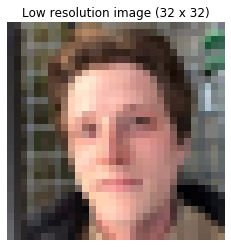

In [41]:
plt.imshow(np.array(transforms.ToPILImage()(img_lr[0].cpu())))
plt.title("Low resolution image ({} x {})".format(img_lr_res[0], img_lr_res[0]))
plt.axis('off');

### Generator - StyleGAN

As in the original paper, we will be using pretrained *StyleGAN* downloaded from the Internet. First, make sure you have `synthesis.pt` and `gaussian_fit.pt` in `models` folder.

In [42]:
!mkdir -p models/ img/
!wget -nc -O "models/synthesis.pt" https://drive.google.com/uc?id=1TCViX1YpQyRsklTVYEJwdbmK91vklCo8
!wget -nc -O "models/gaussian_fit.pt" https://drive.google.com/uc?id=14R6iHGf5iuVx3DMNsACAl7eBr7Vdpd0k

File ‘models/synthesis.pt’ already there; not retrieving.
File ‘models/gaussian_fit.pt’ already there; not retrieving.


Now we are ready to load it:

In [43]:
generator = G_synthesis().cuda()
generator.load_state_dict(torch.load("models/synthesis.pt"));

StyleGAN's generator conists of three parts:
 -  Mapping: $R^{512} \rightarrow R^{512}$
 -  Tiling function: $R^{512} \rightarrow R^{18\times 512}$
     - This functions tiles (repeats) given tensor 18 times.
 -  Synthesis: $R^{18\times 512} \times \textit{noise} \rightarrow R^{1024\times 1024}$.
 
To generate an image, initialize latent vector $z$ randomly and feed it through the above.
However, we can skip the mapping provided we fit $z$ to the mapping latent distibution.
Again, will be using already pertrained data.
`gaussian_fit` is a dictionary containing mean and standard deviation of the mapping latent:

In [44]:
gaussian_fit = torch.load("models/gaussian_fit.pt");
gaussian_fit.keys()

dict_keys(['mean', 'std'])

To fit $z$, we multiply it by the mean, add the standard deviation and feed through Leaky ReLU activation function:

In [45]:
lrelu = torch.nn.LeakyReLU(negative_slope=0.025);

Last but not least, we need to freeze StyleGAN parameters.
What PULSE optimizes is the latent vector $z$ itself and the StyleGAN is used to generate images solely!

In [46]:
for param in generator.parameters():
    param.requires_grad = False

### StyleGAN: Noise
Besides a latent vector, StyleGAN's synthesis takes one more parameter: noise.
The noise contols artistic features of generated image.
There are 18 noise vectors, each for one interal layer of the synthesis.

In PULSE, they proposed following noise types:

 - first 5 layers get a trainable noise
 - next layers get a fixed, non-trainable noise
 - the last, 18-th layer gets no noise (fixed zero noise)

In [47]:
noise_trainable = [torch.randn((1, 1, 2**(i//2+2), 2**(i//2+2)), 
                   dtype=torch.float, device='cuda', requires_grad=True) 
                   for i in range(5)]

noise_fixed = [torch.randn((1, 1, 2**(i//2+2), 2**(i//2+2)), 
               dtype=torch.float, device='cuda', requires_grad=False) 
               for i in range(5, 17)]

noise_zero = [torch.zeros((1, 1, 2**(17//2+2), 2**(17//2+2)), 
              dtype=torch.float, device='cuda', requires_grad=False)]

noise = noise_trainable + noise_fixed + noise_zero

### The Latent Vector

Surprisingly, to draw **uniformly** from the hypersphere, first we gotta draw a latent vector from normal distibution, and then normalize it by the sphere radius
([Method 19](http://extremelearning.com.au/how-to-generate-uniformly-random-points-on-n-spheres-and-n-balls/)).
The latent tensor contains one, $512$-dimensional vector.

In [48]:
latent = torch.randn((1, 1, 512), dtype=torch.float, device='cuda', requires_grad=True)

The latent vector has to lie on the hypersphere of radius $r =\sqrt{511}$.
To enforce that, simply divide the vector by the radius length.
Why is the radius $\sqrt{511}$? Because it's where mass of the gaussian lies.
Check the paper, Section 6.2 for detailed explanation.

However, we won't divide the latent by $\sqrt{511}$.
Instead, we will exploit the following fact: expected length of a random $512$-dim vector is $\approx\sqrt{511}$.
We will take $r$ as the length of the initailly randomly drawn vector.
Thus we won't be on the sphere _precisely_, but _somewhere close_ to it.
This way, it is expected to obtain a little bit more _diversed_ images.

In [49]:
radius = 0
with torch.no_grad():
    radius = latent.norm(dim=2, keepdim=True)

One can verify that the randomly generated vector _indeed is_ close the hypersphere of radius $\sqrt{511}$:

In [50]:
print("| sqrt(511) - |z| | = {:.4}".format(np.abs(np.sqrt(511) - radius.cpu().item())))

| sqrt(511) - |z| | = 0.9747


### Optimizer
We will use Adam optimizer with learning rate = 0.4.
Again, what we optimize in PULSE is just the latent vector and the trainable noise for the StyleGAN.

In [51]:
optim = torch.optim.Adam([latent] + noise_trainable, lr=0.4)

Note, that after the optimzer step the latent vector might not lie on the sphere anymore.
We will enforce that constraint manually, in the "training" loop.

### The Loss Function
PULSE searches for a latent vector $z$ that minimizes:
$$ | DS(G(z)) - I_{LR} |_p^p $$

where $I_{LR}$ is given low-resolution image (`img_lr` in the code), $G$ is a `generator` and $DS$ stands for a downsampling function.
We will set $p=2$, that is, we will minimize _mean square error:

In [52]:
mse = nn.MSELoss().cuda()

### Downsample function
As in the paper, we choose bicubic interpolation to downsample generated super-resolution image.
If you wish to learn more about the bicubic interpolation, check out awesome [video by Computerphile](https://www.youtube.com/watch?v=poY_nGzEEWM).

In [53]:
def ds(img_sr, target_res):
    """Downsamples `img` bicubically to `target_res` resolution"""
    return nn.functional.interpolate(img_sr, target_res, mode='bicubic', align_corners=False)

We are almost ready to run the PULSE. 

### PULSE
At every step of PULSE, we will:
 1. Tile the latent vector $z$ 18 times
 2. Fit the $z$ to the mapping gaussian
 3. Generate supe-resolution image `img_sr`
     * StyleGAN outputs values in $[-1, 1]$, we should normalize it back to $[0, 1]$
 4. Downsample `img_sr` image to match the resolution of given low-resolution image `img_lr`
 4. Compute MSE loss between given `img_lr` and downsampled `img_sr`
 5. Save some intermediate results for further analysis
 6. Optimize $z$
 7. Project $z$ back to the hypersphere, that is:
     * first project it to the unit sphere (i.e. divide $z$ by its length)
     * then multiply $z$ by radius $r$.

In [61]:
generated_imgs = []
steps = 100

for step in range(steps):
   
    optim.zero_grad()

    #  1. Tile the latent vector
    z = latent.expand(-1, 18, -1)
    
    #  2. Fit z to gaussian
    z = lrelu(z * gaussian_fit["std"] + gaussian_fit["mean"])

    #  3. Generate super-resolution image
    img_sr = generator(z, noise)
    img_sr = (img_sr + 1.0) / 2.0
    
    #  4. Downsample generated image
    img_sr_ds = ds(img_sr, img_lr_res)
        
    #  5. Get the loss
    loss = mse(img_lr, img_sr_ds)
    
    #  6. Save some images
    if step % (steps / 10) == 0:
        generated_imgs.append(img_sr.detach().clone())
        
    #  7. Optimize 
    loss.backward()
    optim.step()
    
    #  8. Project z back to the hypersphere
    with torch.no_grad():
        latent.div_(latent.norm(dim=2, keepdim=True) + 1e-10)
        latent.mul_(radius)

Note might not necessarily get a satisfactory image.
We consider generated image _satisfactory_ if the loss is less than 0.002.

In [62]:
print("Loss: {:.4}. ".format(loss), end='')
if loss >= 0.002:
    print("Generated image might not be satisfactory. Try running the PULSE loop again.")

Loss: 0.004636. Generated image might not be satisfactory. Try running the PULSE loop again.


### Display results
Let's have some fun with the results.
Let's plot original image, generated one, and its downsampled version:

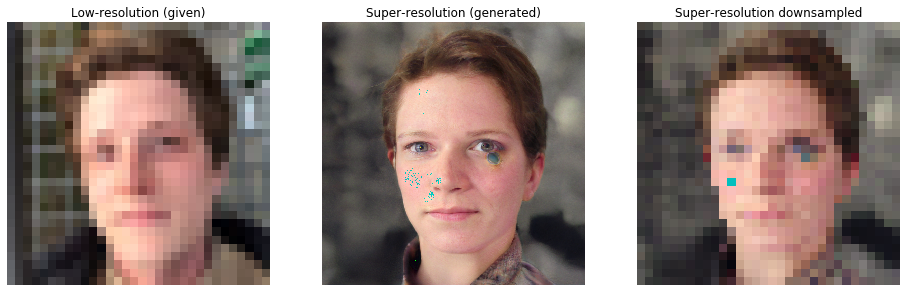

In [60]:
def to_numpy(img):
    """Converts a tensor image to numpy array."""
    return np.array(transforms.ToPILImage()(img.cpu()))

before = to_numpy(img_lr[0])
after = to_numpy(img_sr[0])
after_lr = to_numpy(img_sr_ds[0])

titles = ['Low-resolution (given)', 'Super-resolution (generated)', 'Super-resolution downsampled']
imgs = [before, after, after_lr]

fig, axs = plt.subplots(1, 3, figsize=(16, 12))

for a, img, title in zip(axs, imgs, titles):
    a.imshow(img)
    a.axis('off')
    a.set_title(title)

### Show intermediate pics
Also, let's visulize the generative process by displaying intermediately generated images:

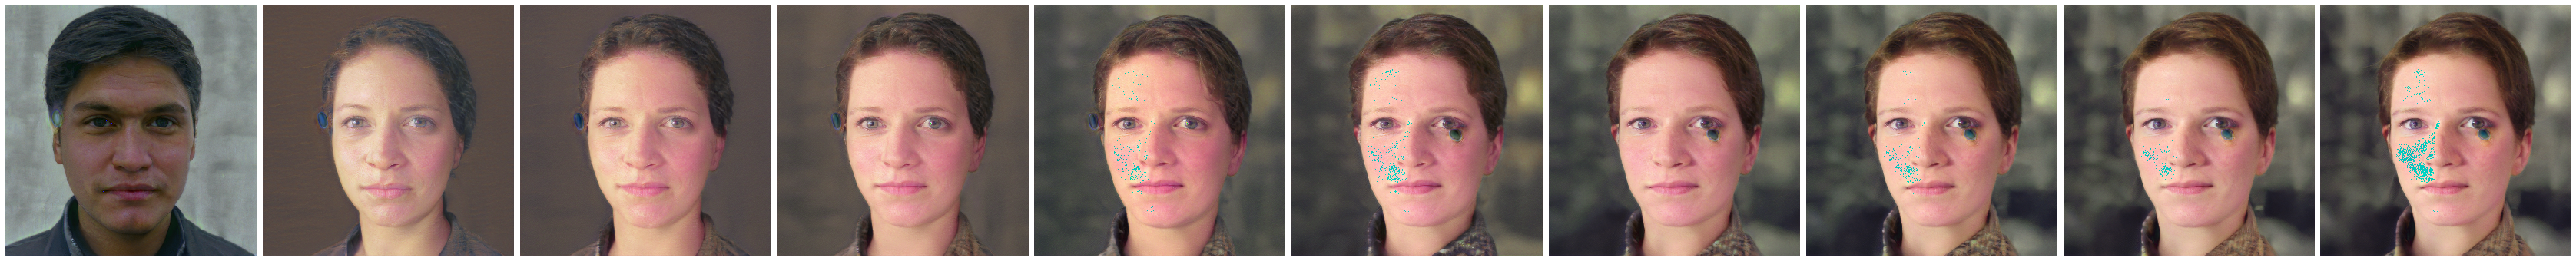

In [57]:
nimg = len(generated_imgs)
fig, axs = plt.subplots(1, nimg, figsize=(6*nimg, 6))

for a, img in zip(axs, generated_imgs):
    a.imshow(to_numpy(img[0]))
    a.axis('off')
plt.subplots_adjust(wspace=0.0, hspace=0.0)

### Genereate a gif
In addition to the above, we may generate animated gif. The result saves to `out.gif`.

In [58]:
gif = [transforms.ToPILImage()(img[0].cpu()).resize((256, 256)) for img in generated_imgs]

gif[0].save('out.gif', save_all=True, append_images=gif[1:], loop=0, duration=100)

![Animated face](out.gif "animated face")

### Further reading
If you wish to learn more, check out the original paper:
 - in [CVPR 2020 proceedings](https://openaccess.thecvf.com/content_CVPR_2020/papers/Menon_PULSE_Self-Supervised_Photo_Upsampling_via_Latent_Space_Exploration_of_Generative_CVPR_2020_paper.pdf)
 - or its [arxiv vesion](https://arxiv.org/abs/2003.03808) – this one includes a comprehensive appendix

Also, give my medium.com article a try.

### Remarks

In the above notebook I have used:
 - `stylegan.py` - StyleGAN code by [@lernapparat](https://github.com/lernapparat/lernapparat/blob/master/style_gan/pytorch_style_gan.ipynb), later adapted by the paper authors
 - pretrained StyleGAN's Synthesis module (`models/synthesis.pt`) and gaussain fit data (`models/gaussian_fit.pt`) provided by the paper authors
 
I have written this notebook as well as medium.com article as a part of academic project at The University of Tokyo.

---
お疲れ様！